chessboards\c1Left.png


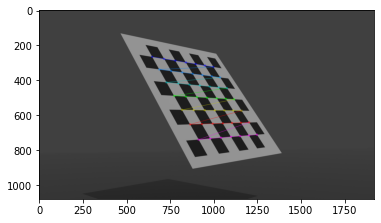

chessboards\c1Right.png


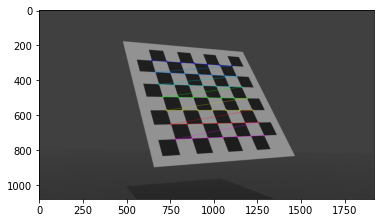

chessboards\c2Left.png


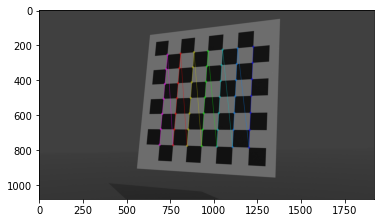

chessboards\c2Right.png


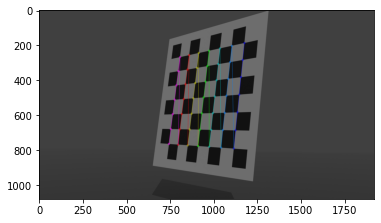

chessboards\c4Left.png


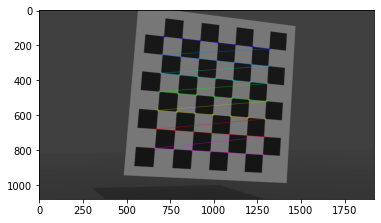

chessboards\c4Right.png


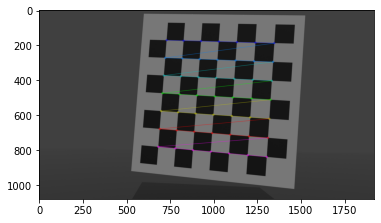


 rvecs rodrigues : 
 [[ 0.9805766  -0.0718773  -0.1824916 ]
 [ 0.08296156  0.99509733  0.05383945]
 [ 0.17772707 -0.06793349  0.98173221]]

 tvecs : 
 [[-2.29982476]
 [-3.66546698]
 [19.81589073]]

 matrice RT: 
 [[ 0.9805766  -0.0718773  -0.1824916  -2.29982476]
 [ 0.08296156  0.99509733  0.05383945 -3.66546698]
 [ 0.17772707 -0.06793349  0.98173221 19.81589073]]

 matrice de projection : mtx @ matrice RT  
 [[ 2.22944962e+03 -2.16122550e+02  5.59150657e+02  1.41915121e+04]
 [ 2.70023096e+02  2.05272327e+03  6.42408284e+02  2.98882882e+03]
 [ 1.77727065e-01 -6.79334893e-02  9.81732210e-01  1.98158907e+01]]

 centre optique gauche : 
 [[ -0.96257291]
 [  4.82835379]
 [-19.67625017]
 [  1.        ]]
[[-1.14738298e-03 -1.51160330e+00  9.81909580e+02]
 [-1.58288228e+00 -2.48925538e-04  1.76843099e+04]
 [ 1.01617006e+03 -1.47438915e+04 -1.90044521e+06]]
26
26


In [13]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from mathutils import geometry as pygeo
from mathutils import Vector
import json

chessboardSize = (7,7)
# termination criteria for the cornerSubPix algorithm
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp stores coordinates 
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

# Arrays to store object points and image points from each images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = sorted(glob.glob('chessboards/*.png'))

for fname in images:
    
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   
    # Find the chess board corners (points where 2 black squares touch each other)
    ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)
    
    # If found, add object points and image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, chessboardSize, corners2, ret)
        print(fname)
        plt.imshow(img)
        plt.show()
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#rotation matrix => convert vector to matrix
rmatLeft = cv.Rodrigues(rvecs[4])[0]
rmatRight = cv.Rodrigues(rvecs[5])[0]

print ('\n rvecs rodrigues : \n', rmatLeft)
print ('\n tvecs : \n', tvecs[4])

#full [R|t] matrix => add t in R
rotMatRight = np.concatenate((rmatRight,tvecs[5]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecs[4]), axis=1)

print ('\n matrice RT: \n', rotMatLeft)

#camera matrix (A [R|t])
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

print('\n matrice de projection : mtx @ matrice RT  \n',camLeft)

# find cx and cy for both cameras
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
#print('\n np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0) \n',np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0))
#print('\n np.transpose([[0,0,0,1]] : \n',np.transpose([[0,0,0,1]]))
print('\n centre optique gauche : \n',camWorldCenterLeft)

'''Compute vectorial product'''
def crossMat(v):
    v = v[:,0]
    return np.array([ [ 0,-v[2],v[1] ],[ v[2],0,-v[0] ],[ -v[1],v[0],0 ] ])


def matFondamental(camLeft,centerRight,camRight):
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))

fundamentalMatrix = matFondamental(camRight,camWorldCenterLeft,camLeft)

print(fundamentalMatrix)

'''Get all red pixels from the image'''
def getRed(fname):
    img = cv.imread(fname)
    #acces only R channel from BGR 
    red = img[:,:,2]
    #keep only pixels between 127 and 255 in the red channel
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)
    return mask


def getRedAvg(fname):
    red = getRed(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            #same as in find epilines
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints

'''Find epilines on right image of all given red points of left image'''
def getEpiLine(F,points):
    return F @ points

'''returns epilines (on right camera image) for all red points of the red line (of the left camera), from all images'''
def findEpilines(path):
    epilines = []
    scanLeft = sorted(glob.glob(path + '/*.png'))
    for img in scanLeft:           
        red = getRed(img)
        tempEpilines = []
        pointsLeft = [[],[],[]]
        ps = []
        
        #i is the number of the line
        for i, line in enumerate(red):
            for pixel in line:
                if pixel != 0:
                    pixel = 1
            try:
                #weighted average => (0*0 + 1*0 + 2*0 + ... + 1248 * 1 + 1249 * 0) / n° of red pixels
                #for instance => (1261+1262+1267)/3 = 1263.33
                #give position of the red line in x axis
                pointsLeft[0].append(np.average(range(1920), weights = line))
                pointsLeft[1].append(i) # y axis
                pointsLeft[2].append(1)
                ps.append([(np.average(range(1920), weights = line)), i])
            except:
                pass
        #from red line on left image, find corresponding epiline on right image
        #try to use c2.computeCorrespondEpilines
        #epilinesRight = getEpiLine(fundamentalMatrix, pointsLeft)
        ps = np.int32(ps)
        epilinesRight = cv.computeCorrespondEpilines(ps.reshape(-1,1,2), 1, fundamentalMatrix)
        tempEpilines.append(pointsLeft)        
        tempEpilines.append(epilinesRight)
        epilines.append(tempEpilines)
    return epilines

# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')
print(len(epl))

'''equation of a ligne => returns a value for y for a given x and coefficients'''
def lineY(coefs,x):
    a,b,c = coefs
    return-(c+a*x)/b

'''Find red points that are on an epiline, for each picture'''
def eplRedPoints(path,EplRight):
    points = []
    scanRight = sorted(glob.glob(path + '/*.png'))
    for l, img in enumerate(scanRight):            
        redPoints = getRedAvg(img)
        pointsRight = [[],[],[]]
        eplImg = EplRight[l] #keep only epiline and not red points (EplRight[l][0])
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i]) #average position
                y = int(lineY(eplImg[:,i],x)) #use of y = (-ax+c)/b to find y position
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
            except:
                pass
        points.append(pointsRight)
    return points

pointsRight = eplRedPoints('scanRight/',epl)
print(len(pointsRight))
def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))


def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # get world/object 3D coordinates of all points 
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # characteristics points of retro projected lines
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # display retro projected lines
    
    
    # intersection between two retroprojected lines = real world point
    # Essayer d'utiliser cv.triangulatePoints()
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)

def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)

point = getObjectPoint()


[]


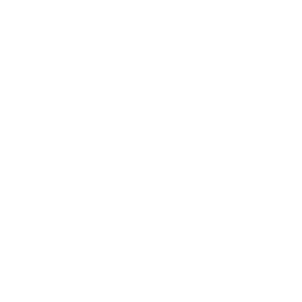

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])

def drawSurfaceObject(points):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(points[0,:],points[1,:],points[2,:])     

    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()
    
def drawPointObject(points):
    figure = plt.figure()
    ax = Axes3D(figure)
    my_cmap = plt.get_cmap('hsv')
    ax.scatter3D(points[0,:],points[1,:],points[2,:],s=100,alpha = 0.8, c =(points[0,:]), cmap = my_cmap, marker='.', )     
        
    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()

print(point)
drawPointObject(point)